In [32]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('perrin-freres-monthly-champagne-.csv')

In [3]:
data.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
data.columns = ['Month','Sales']
data.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [5]:
data.shape

(107, 2)

In [6]:
data.isnull().sum()

Month    1
Sales    2
dtype: int64

In [7]:
data.dropna(inplace = True)

In [8]:
data.isnull().sum()

Month    0
Sales    0
dtype: int64

In [9]:
data.dtypes

Month     object
Sales    float64
dtype: object

In [10]:
data['Month'] = pd.to_datetime(data['Month'])

In [11]:
data.dtypes

Month    datetime64[ns]
Sales           float64
dtype: object

In [12]:
data.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [13]:
## For Time Series we need time related as index
data.set_index('Month',inplace = True)

In [14]:
data.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [15]:
data.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


<AxesSubplot:xlabel='Month'>

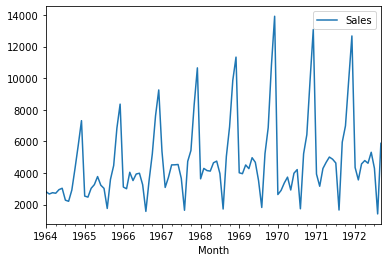

In [16]:
data.plot()

>Looking At the above graph we can say that the data is based on season or we have seasonal data

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF test statistics','p-value','Lags Used','Number of Observation used']
    for value,label in zip(result,labels):
        print('{} : {}'.format(label,value))
    if result[1] <= 0.05:
        print('Strong Evidence against null hypothesis,reject the null hypo & data is stationery')
    else:
        print('Weak Evidence against null hypothesis,accept the null hypo & data is not stationery')

In [19]:
adfuller_test(data['Sales'])

ADF test statistics : -1.8335930563276297
p-value : 0.3639157716602417
Lags Used : 11
Number of Observation used : 93
Weak Evidence against null hypothesis,accept the null hypo & data is stationery


In [20]:
## data must be stationery to apply time - series analysis

In [21]:
data['Sales'].shift(1)

Month
1964-01-01       NaN
1964-02-01    2815.0
1964-03-01    2672.0
1964-04-01    2755.0
1964-05-01    2721.0
               ...  
1972-05-01    4788.0
1972-06-01    4618.0
1972-07-01    5312.0
1972-08-01    4298.0
1972-09-01    1413.0
Name: Sales, Length: 105, dtype: float64

In [22]:
data['Sales First Diff'] = data['Sales']- data['Sales'].shift(1)

In [23]:
data.head()

,Sales,Sales First Diff
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0


In [24]:
data['Seasonal First Diff'] = data['Sales']- data['Sales'].shift(12)

In [25]:
data.head()

,Sales,Sales First Diff,Seasonal First Diff
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN


In [26]:
adfuller_test(data['Seasonal First Diff'].dropna())

ADF test statistics : -7.626619157213163
p-value : 2.060579696813685e-11
Lags Used : 0
Number of Observation used : 92
Strong Evidence against null hypothesis,reject the null hypo & data is stationery


<AxesSubplot:xlabel='Month'>

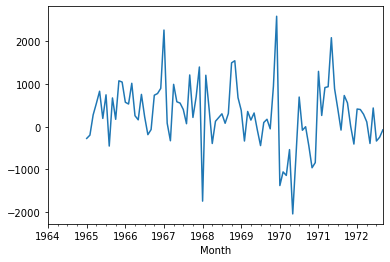

In [27]:
data['Seasonal First Diff'].plot()

> ARIMA (Auto-Regressive Integrating Moving Average)

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

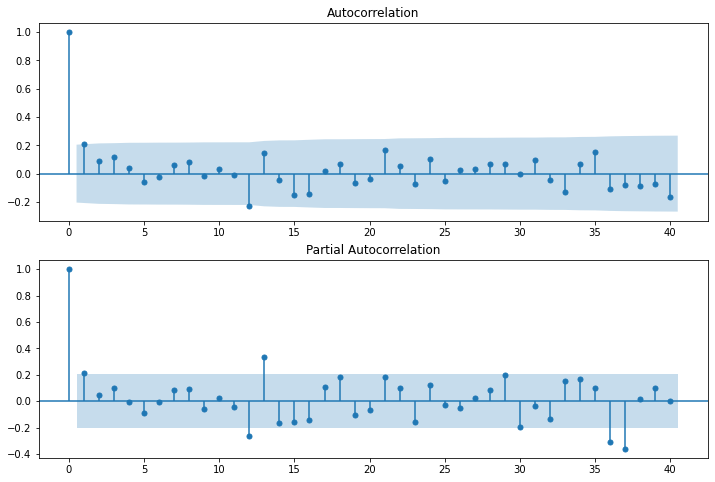

In [29]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot(211)
fig=plot_acf(data['Seasonal First Diff'].iloc[13:],lags=40,ax=ax1)

ax2 = plt.subplot(212)
fig=plot_pacf(data['Seasonal First Diff'].iloc[13:],lags=40,ax=ax2)

In [30]:
from statsmodels.tsa.arima_model import ARIMA

In [33]:
model = ARIMA(data['Sales'],order=(1,1,1))

In [34]:
model = model.fit()

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Sat, 08 May 2021   AIC                           1910.251
Time:                        12:51:14   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7853     12.405      1.837      0.066      -1.529      47.099
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [36]:
data['Forecast'] = model.predict(start=50,end=103,dynamic=True)

In [37]:
data.tail(10)

,Sales,Sales First Diff,Seasonal First Diff,Forecast
Month,,,,
1971-12-01,12670.0,2819.0,-406.0,22.78527
1972-01-01,4348.0,-8322.0,414.0,22.78527
1972-02-01,3564.0,-784.0,402.0,22.78527
1972-03-01,4577.0,1013.0,291.0,22.78527
1972-04-01,4788.0,211.0,112.0,22.78527
1972-05-01,4618.0,-170.0,-392.0,22.78527
1972-06-01,5312.0,694.0,438.0,22.78527
1972-07-01,4298.0,-1014.0,-335.0,22.78527
1972-08-01,1413.0,-2885.0,-246.0,22.78527


<AxesSubplot:xlabel='Month'>

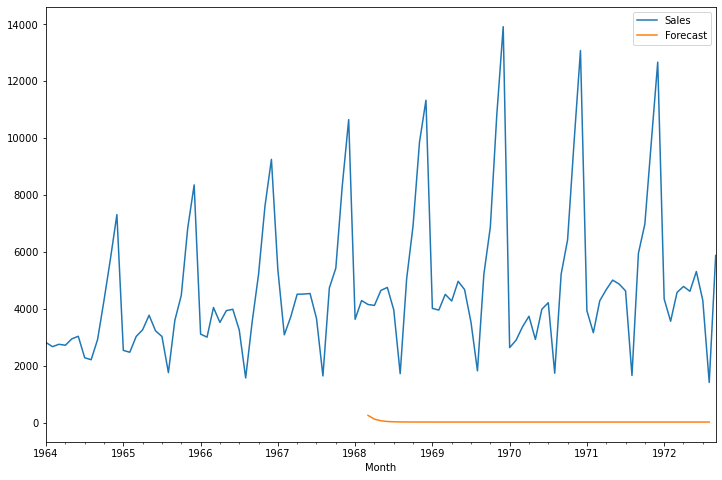

In [38]:
data[['Sales','Forecast']].plot(figsize=(12,8))

In [39]:
## seasonal data -- Arima will not work 
## but Sarimax will work

In [40]:
import statsmodels.api as sm

In [41]:
model1 = sm.tsa.statespace.SARIMAX(data['Sales'],order=(1,1,1),seasonal_order=(1,1,1,12))

In [42]:
result = model1.fit()

In [43]:
data['Forecast_Sarimax'] = result.predict(start=50,end=103,dynamic=True)

In [44]:
data.tail(15)

,Sales,Sales First Diff,Seasonal First Diff,Forecast,Forecast_Sarimax
Month,,,,,
1971-07-01,4633.0,-241.0,416.0,22.78527,5859.020633
1971-08-01,1659.0,-2974.0,-79.0,22.78527,3880.211240
1971-09-01,5951.0,4292.0,730.0,22.78527,6813.535178
1971-10-01,6981.0,1030.0,557.0,22.78527,7671.914866
1971-11-01,9851.0,2870.0,9.0,22.78527,10486.403480
1971-12-01,12670.0,2819.0,-406.0,22.78527,12734.526154
1972-01-01,4348.0,-8322.0,414.0,22.78527,6192.775051
1972-02-01,3564.0,-784.0,402.0,22.78527,6372.508875
1972-03-01,4577.0,1013.0,291.0,22.78527,6733.655686


<AxesSubplot:xlabel='Month'>

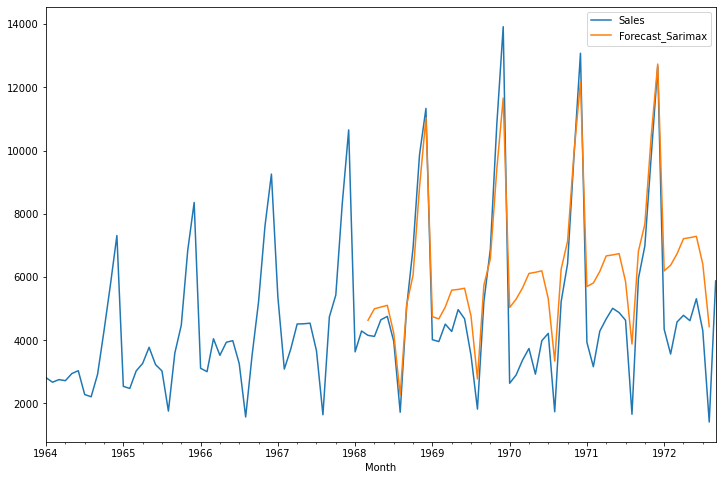

In [45]:
data[['Sales','Forecast_Sarimax']].plot(figsize=(12,8))

## Prediction for Future Dataset 

In [46]:
from pandas.tseries.offsets import DateOffset

In [47]:
future_dates = [data.index[-1]+DateOffset(months=x) for x in range(0,24)]

In [48]:
Future_Dataset = pd.DataFrame(index=future_dates[1:],columns=data.columns)

In [49]:
Future_Dataset.tail()

,Sales,Sales First Diff,Seasonal First Diff,Forecast,Forecast_Sarimax
1974-04-01,NaN,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN,NaN


In [50]:
future_data = pd.concat([data,Future_Dataset])

In [51]:
future_data.shape

(128, 5)

In [52]:
future_data['Forecast_Sarimax2'] = result.predict(start=104,end=124,dynamic=True)

<AxesSubplot:>

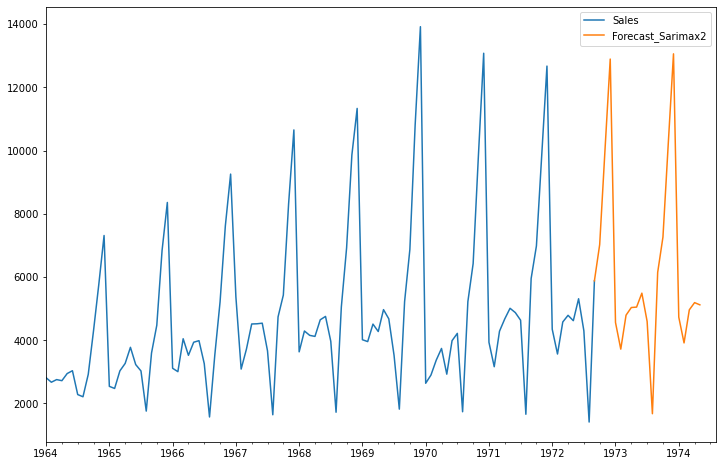

In [53]:
future_data[['Sales','Forecast_Sarimax2']].plot(figsize=(12,8))